## Data Exploration Notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import json
from accel_utils import AccelUtils

In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
# Keep all params in a yaml file for 
with open('params.json', 'r') as f:
    params = json.load(f)
    
print('Params:')
print(json.dumps(params, indent=2))

# Some values that will remain constant throughout experiments
csv_list = [f for f in os.listdir(params['data_dir']) if os.path.splitext(f)[1] == '.csv']
num_subj = len(csv_list)
max_resample_pts = int(params['window_size_sec'] // params['resample_dt']) - 3

print(f'Number of files/subjects: {num_subj}')
print(f'Each sample will be {max_resample_pts} time steps')


Params:
{
  "data_dir": "./user_data",
  "filt_avg_power": 2.0,
  "filt_dc_ratio": 0.7,
  "filt_power_ratio": 0.5,
  "filt_min_samples_per_subj": 8,
  "max_dt": 0.035,
  "filt_min_timesteps_per_sample_ratio": 0.9,
  "resample_dt": 0.03,
  "window_size_sec": 4.3
}
Number of files/subjects: 22
Each sample will be 140 time steps


In [14]:
per_user_all_data = AccelUtils.read_all_user_data(params['data_dir'], num_subj)
    

In [15]:
per_user_all_data[0].describe()

,t,x_acc,y_acc,z_acc,mag_acc
count,5069.00000,5069.000000,5069.000000,5069.000000,5069.000000
mean,76.81745,-3.554254,8.557989,-0.844095,10.072604
std,44.23811,2.486629,2.956517,2.913708,2.922008
min,0.00000,-9.343600,0.000000,-7.927000,2.956867
25%,38.57000,-5.284700,6.129200,-2.601500,7.851683
50%,76.82000,-3.486800,8.921300,-1.144100,9.881105
75%,115.01000,-2.179300,10.651000,-0.040861,12.184767
max,154.20000,10.951000,15.786000,12.599000,17.870653


## Let's look at the data
Bird's eye view of all 22 subjects' data.

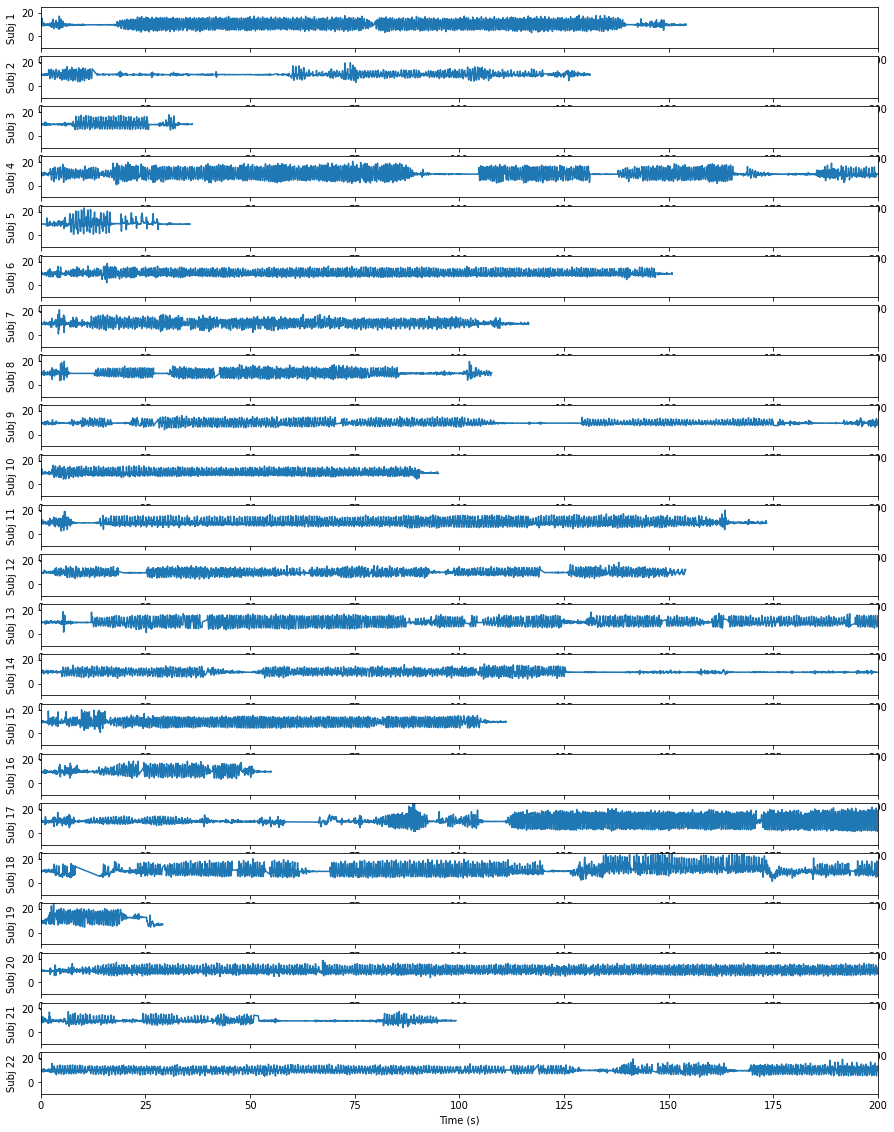

In [16]:
fig, axs = plt.subplots(num_subj, 1, figsize=(15, 20))

for i in range(num_subj):
    axs[i].plot(per_user_all_data[i]['t'], per_user_all_data[i]['mag_acc'])
    axs[i].set_xlim(0, 200)
    axs[i].set_ylim(-10, 25)
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel(f'Subj {i+1}')

Let's check on the time intervals between samples in the data.  

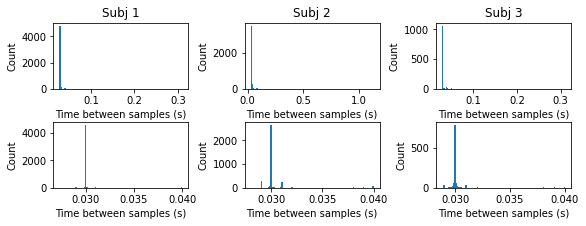

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(8, 3))
for i in range(3):
    time_list = per_user_all_data[i]['t'].values
    diffs = time_list[1:] - time_list[:-1]
    axs[0][i].hist(diffs, bins=100)
    axs[0][i].set_xlabel('Time between samples (s)')
    axs[0][i].set_ylabel('Count')
    axs[0][i].set_title(f'Subj {i+1}')

    diffs_clipped = diffs[diffs <= 0.04]
    axs[1][i].hist(diffs_clipped, bins=100)
    axs[1][i].set_xlabel('Time between samples (s)')
    axs[1][i].set_ylabel('Count')
    
fig.tight_layout(pad=0.2)


Looks like like consistently around 0.03s/sample with some outliers...

## The Plan
We need to extract sections of each person's walking data that is "regular."  This means that it fits the following criteria:
1. Long enough to capture multiple full periods of oscillations
1. Signal is approximately stationary
2. Average absolute value around DC is above a given threshold
3. No large gaps in time

Let's pick some values for the above, and experiment with the classification task.  

## Sampling Strategy
Use the above criteria to extract labeled samples from all subjects.  Some subjects have shorter total time, and may have less samples.  Samples for training can be overlapping, though testing samples must have zero overlap with other testing or training samples

Due to the imperfect time sampling, we'll need to resample each time slice at exactly 0.03s.


Subject 17 (index 16) has the most diverse data.  Test out the above on it (these results are after hand-tuning the thresholds):

Show which time-windows are considered valid by the specified criteria


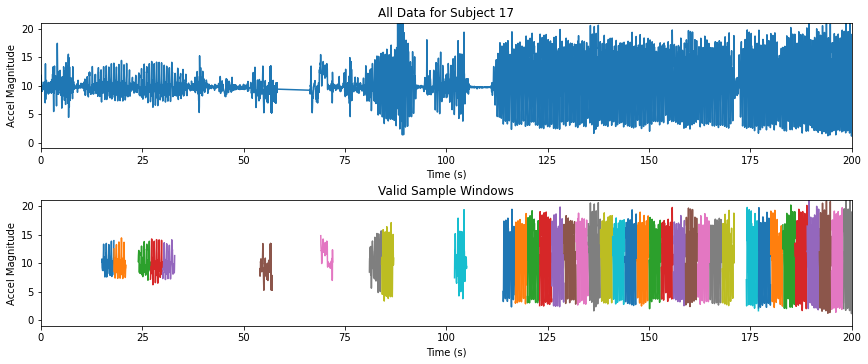

In [25]:
i_subj = 16
df = per_user_all_data[i_subj]
AccelUtils.display_time_slices_for_subject(df, params['window_size_sec'], params['max_dt'], i_subj)

### Zoom in for a closer look
Let's actually zoom in on a couple samples.  We're looking for:
1. Visual distinguishability between subjects
2. Confirming that resampling is preserving the core characteristics of the time series

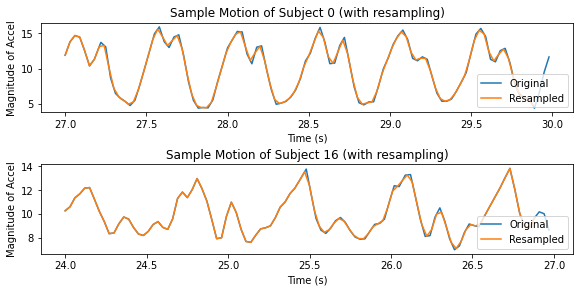

In [27]:
fig,axs = plt.subplots(2, 1, figsize=(8,4))
for p,i_subj in enumerate([0, 16]):
    df = per_user_all_data[i_subj]
    
    valid_windows = AccelUtils.extract_valid_time_windows_for_subj(df, params['window_size_sec'], params['max_dt'])
    ts, mags = AccelUtils.resample_and_truncate(valid_windows[2], params['resample_dt'], max_resample_pts)
    
    axs[p].plot(valid_windows[2]['t'], valid_windows[2]['mag_acc'])
    axs[p].plot(ts, mags)
    axs[p].set_xlabel('Time (s)')
    axs[p].set_ylabel('Magnitude of Accel')
    axs[p].set_title(f'Sample Motion of Subject {i_subj} (with resampling)')
    axs[p].legend(['Original', 'Resampled'], loc='lower right')

fig.tight_layout(pad=0.5)

It does look like frequency information might be useful here!

Computing the periodogram of the signals should work.  Let's do that along with identifying the three biggest peaks of each.  It's a little awkward to use the top three peaks as features, but it should be good for data exploration.

In [43]:
def plot_samples_for_subj(window_list, params, fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots()
        
    max_power = 0
    fpeaks_disp = []
    powers_disp = []
    for i in range(3):
        fs, pxx, sample_fpeaks, sample_powers = AccelUtils.compute_periodogram_with_peaks(
            window_list[i],
            params['resample_dt'],
            max_resample_pts,
            max_peaks=3)

        ax.plot(fs, pxx)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Sqrt(Spectral Power)')
        ax.set_title('Power spectrum of 3 samples from same subject')
        fpeaks_disp.append(', '.join([f'{f:.2f}' for f in sample_fpeaks]))
        powers_disp.append(', '.join([f'{p:.2f}' for p in sample_powers]))

    for f in sample_fpeaks:
        ax.plot([f, f], [0, 3], 'b-.', lw=0.5)
        
    for i in range(3):
        print(f'Top three dominant frequences for subj {i_subj}, sample {i}: {fpeaks_disp[i]}')
        
    print()
    for i in range(3):
        print(f'Power of three dominant freqs for subj {i_subj}, sample {i}: {powers_disp[i]}')
    
    print()
    fig.tight_layout(pad=0.3)

    return fig, ax

Top three dominant frequences for subj 0, sample 0: 2.06, 4.12, 5.84
Top three dominant frequences for subj 0, sample 1: 2.06, 4.12, 5.84
Top three dominant frequences for subj 0, sample 2: 2.06, 4.12, 5.84

Power of three dominant freqs for subj 0, sample 0: 0.69, 0.15, 0.16
Power of three dominant freqs for subj 0, sample 1: 0.68, 0.19, 0.12
Power of three dominant freqs for subj 0, sample 2: 0.70, 0.18, 0.12

Top three dominant frequences for subj 7, sample 0: 1.72, 3.44, 5.15
Top three dominant frequences for subj 7, sample 1: 1.72, 2.41, 5.84
Top three dominant frequences for subj 7, sample 2: 1.72, 3.44, 5.50

Power of three dominant freqs for subj 7, sample 0: 0.62, 0.23, 0.15
Power of three dominant freqs for subj 7, sample 1: 0.61, 0.21, 0.18
Power of three dominant freqs for subj 7, sample 2: 0.60, 0.19, 0.21

Top three dominant frequences for subj 16, sample 0: 1.72, 3.09, 4.81
Top three dominant frequences for subj 16, sample 1: 1.72, 3.09, 4.81
Top three dominant frequence

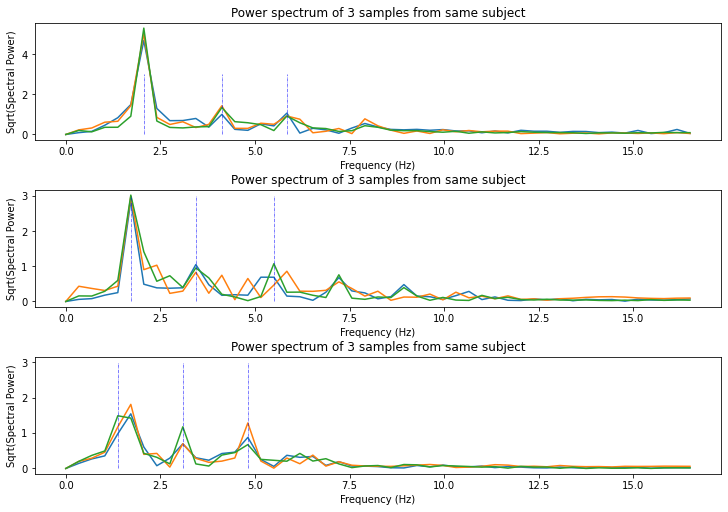

In [53]:
fig, axs = plt.subplots(3, 1, figsize=(10,7))
for i,i_subj in enumerate([0, 7, 16]):
    another_subj_windows = AccelUtils.extract_valid_time_windows_for_subj(
        per_user_all_data[i_subj],
        params['window_size_sec'],
        params['max_dt'])

    plot_samples_for_subj(another_subj_windows, params, fig, axs[i])